In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install xgboost lightgbm

In [2]:
from google.colab import files
uploaded = files.upload()

Saving internal_df.csv to internal_df.csv


In [3]:
internal_df = pd.read_csv('internal_df.csv')
internal_df.head()

,generated,text,word_count,sentence_count,avg_word_length,stopwords_count,lexical_diversity,flesch_reading_ease,smog_index,flesch_kincaid_grade,...,sentiment,polarity,subjectivity,bigram_count,trigram_count,dependency_count,line_break_count,punctuation_count,repetition_count,spelling_errors
0,1.0,As Winston Churchill put it: “Success is not f...,305,14,4.406557,130,0.501639,64.10,11.0,8.2,...,POSITIVE,0.055080,0.471836,262,261,5,7,30,22,35
1,0.0,to show a society how strongly we trust our se...,701,54,3.507846,372,0.262482,93.14,6.8,3.3,...,NEGATIVE,0.130804,0.529211,599,598,1,12,71,70,48
2,1.0,It also opens up the possibility of thinking b...,195,9,4.692308,78,0.610256,45.05,13.3,11.4,...,POSITIVE,0.228545,0.576909,171,170,0,5,16,10,16
3,0.0,Always doing something in sports allows you to...,482,21,3.556017,263,0.348548,85.02,7.3,6.4,...,POSITIVE,0.156250,0.508958,412,411,4,6,42,49,32
4,0.0,Do you think it would be easier FOF technology...,262,10,4.305344,96,0.572519,56.49,12.7,11.1,...,NEGATIVE,0.130978,0.348913,222,221,19,6,23,9,33


In [4]:
def aggregate_internal_features(internal_df):
    aggregated_features = pd.DataFrame()


    # Useful ratios
    aggregated_features['word_count_ratio'] = internal_df['word_count'] / internal_df['sentence_count']
    aggregated_features['stopwords_ratio'] = internal_df['stopwords_count'] / internal_df['word_count']
    aggregated_features['punctuation_ratio'] = internal_df['punctuation_count'] / internal_df['word_count']
    aggregated_features['repetition_ratio'] = internal_df['repetition_count'] / internal_df['word_count']
    aggregated_features['bigram_count_ratio'] = internal_df['bigram_count'] / internal_df['word_count']
    aggregated_features['trigram_count_ratio'] = internal_df['trigram_count'] / internal_df['word_count']
    aggregated_features['dependency_ratio'] = internal_df['dependency_count'] / internal_df['sentence_count']
    aggregated_features['spelling_errors_ratio'] = internal_df['spelling_errors'] / internal_df['word_count']

    # POS tag ratios and any directly included specific features
    pos_columns = [col for col in internal_df.columns if 'pos_' in col]
    for pos_col in pos_columns:
        aggregated_features[f'{pos_col}_ratio'] = internal_df[pos_col] / internal_df['word_count']

    # Retain specific features directly
    retained_features = internal_df[['avg_word_length', 'lexical_diversity', 'flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'polarity', 'subjectivity', 'sentiment']].copy()

    # Combine all features and include the 'generated' column
    final_internal_features = pd.concat([internal_df[['generated']], aggregated_features, retained_features], axis=1)

    return final_internal_features

# Now, you can call this function with your internal DataFrame
final_internal_features = aggregate_internal_features(internal_df)

# Display the head to confirm the structure
print(final_internal_features.head())


   generated  word_count_ratio  stopwords_ratio  punctuation_ratio  \
0        1.0         21.785714         0.426230           0.098361   
1        0.0         12.981481         0.530670           0.101284   
2        1.0         21.666667         0.400000           0.082051   
3        0.0         22.952381         0.545643           0.087137   
4        0.0         26.200000         0.366412           0.087786   

   repetition_ratio  bigram_count_ratio  trigram_count_ratio  \
0          0.072131            0.859016             0.855738   
1          0.099857            0.854494             0.853067   
2          0.051282            0.876923             0.871795   
3          0.101660            0.854772             0.852697   
4          0.034351            0.847328             0.843511   

   dependency_ratio  spelling_errors_ratio  pos__ratio  pos_SPACE_ratio  \
0          0.357143               0.114754    1.006557         0.013115   
1          0.018519               0.068474  

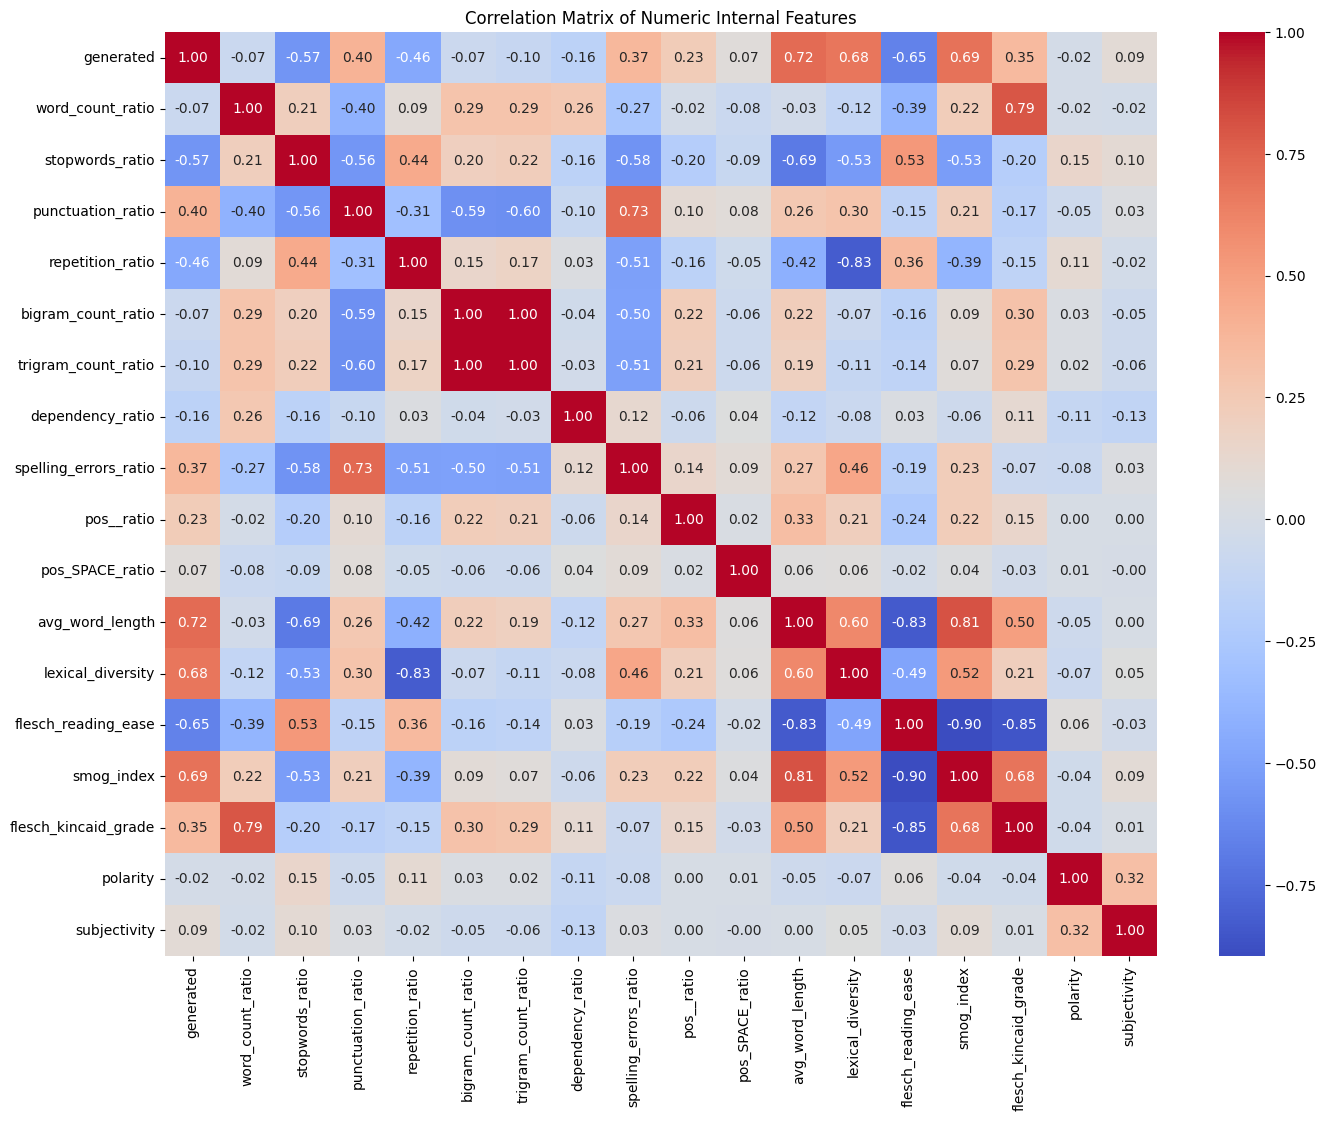

In [7]:
import numpy as np
# Filter only numeric columns for correlation matrix calculation
numeric_features = final_internal_features.select_dtypes(include=[np.number])

# Calculate and plot the correlation matrix for numeric features only
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Internal Features")
plt.show()

In [8]:
# Display the correlation of all features with 'generated'
correlation_internal= correlation_matrix['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_internal)


Correlation with 'generated' column:
 generated                1.000000
avg_word_length          0.722652
smog_index               0.690975
lexical_diversity        0.678662
punctuation_ratio        0.398543
spelling_errors_ratio    0.365555
flesch_kincaid_grade     0.348851
pos__ratio               0.234181
subjectivity             0.092225
pos_SPACE_ratio          0.071966
polarity                -0.019944
bigram_count_ratio      -0.068756
word_count_ratio        -0.074613
trigram_count_ratio     -0.097747
dependency_ratio        -0.159858
repetition_ratio        -0.461239
stopwords_ratio         -0.566064
flesch_reading_ease     -0.653542
Name: generated, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Convert non-numeric categorical columns to numeric values if present
# Map sentiment and polarity columns to numeric values if they exist
if 'sentiment' in final_internal_features.columns:
    final_internal_features['sentiment'] = final_internal_features['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0})
if 'polarity' in final_internal_features.columns:
    final_internal_features['polarity'] = final_internal_features['polarity'].map({'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0})

# Prepare the dataset with selected features based on correlation threshold
correlation_threshold = 0.3
correlation_matrix = final_internal_features.corr()
strong_correlations = correlation_matrix['generated'].abs() > correlation_threshold
selected_features = strong_correlations[strong_correlations].index.tolist()

# Remove 'generated' from the list of selected features for training
selected_features.remove('generated')
X = final_internal_features[selected_features]
y = final_internal_features['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Define a dictionary to store results
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "AUC": []
}

# Function to train and evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else float('nan')

    # Store metrics in results dictionary
    results["Model"].append(model.__class__.__name__)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)
    results["AUC"].append(auc)

# Iterate over each model
for name, model in models.items():
    print(f"Evaluating model: {name}")
    evaluate_model(model, X_train, X_test, y_train, y_test)

# Convert results dictionary to a DataFrame and display
import pandas as pd
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)

Evaluating model: Logistic Regression
Evaluating model: SVM
Evaluating model: Random Forest
Evaluating model: XGBoost
Evaluating model: LightGBM
[LightGBM] [Info] Number of positive: 1830, number of negative: 1906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489829 -> initscore=-0.040691
[LightGBM] [Info] Start training from score -0.040691
Evaluating model: K-Nearest Neighbors
Evaluating model: Naive Bayes
Evaluating model: Gradient Boosting
Evaluating model: AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Performance Comparison:
                        Model  Accuracy  Precision    Recall  F1 Score  \
0          LogisticRegression  0.925054   0.920245  0.935551  0.927835   
1                         SVC  0.906852   0.919149  0.898129  0.908517   
2      RandomForestClassifier  0.955032   0.972043  0.939709  0.955603   
3               XGBClassifier  0.958244   0.960417  0.958420  0.959417   
4              LGBMClassifier  0.958244   0.970213  0.948025  0.958991   
5        KNeighborsClassifier  0.908994   0.907407  0.916840  0.912099   
6                  GaussianNB  0.925054   0.930818  0.923077  0.926931   
7  GradientBoostingClassifier  0.943255   0.947699  0.941788  0.944734   
8          AdaBoostClassifier  0.917559   0.915638  0.925156  0.920372   

        AUC  
0  0.978714  
1       NaN  
2  0.989343  
3  0.989151  
4  0.990436  
5  0.955233  
6  0.973441  
7  0.987489  
8  0.977863  
